In [16]:
import header

import random
import numpy as np
import pandas as pd
from django.db import transaction
from tqdm import tqdm
from v0.index import VectorIndex
from v0.models import Content, MindtoolsSkillGroup, MindtoolsSkillSubgroup

In [17]:
# generate index
skill_subgroup_index = VectorIndex(MindtoolsSkillSubgroup.objects.all())
skill_group_index = VectorIndex(MindtoolsSkillGroup.objects.all())

[v0.VectorIndex_MindtoolsSkillSubgroup] 2022-08-19 12:03:02,861 INFO MainThread [index:_generate_index:46] | Generated index for MindtoolsSkillSubgroup with a total of 87 vectors in 0.1869s
[v0.VectorIndex_MindtoolsSkillGroup] 2022-08-19 12:03:02,934 INFO MainThread [index:_generate_index:46] | Generated index for MindtoolsSkillGroup with a total of 11 vectors in 0.0413s


In [15]:
contents = list(Content.objects.exclude(embedding_all_mpnet_base_v2__isnull=True).values_list('pk', 'embedding_all_mpnet_base_v2'))
content_pks, content_embeddings = zip(*contents)
print(len(contents))

59717


In [18]:
# Do the actual matching batched, much faster
query_vectors = np.array([np.array(x[1]).astype(np.float32) for x in contents]).astype(np.float32)
similarity_values, indices = skill_group_index.index.search(query_vectors, k=1)
skill_group_results_pk = [skill_group_index.pks[indice[0]] for indice in indices]
skill_group_results_value = [value[0] for value in similarity_values]

In [20]:
# we want to do the analysis by skill group, so we need to group by skill group
skill_group_pks = list(MindtoolsSkillGroup.objects.all().values_list('pk', flat=True))
results_grouped = dict.fromkeys(skill_group_pks)

df = pd.DataFrame(columns=skill_group_pks)

for skill_group_pk in skill_group_pks:
    # Do the grouping
    # essentially we are iterating over the results, which are pairs of indices and the pk of the group it got matched to,
    # then seeing if the pk of the group is the same as the current group we are looking at, if it is, we add the pk of the article to the pks_in_group list
    pks_in_group, similarity_values_in_group = zip(*[(content_pks[i], similarity_values[i][0])  for i, skill_group in enumerate(skill_group_results_pk) if skill_group == skill_group_pk])
    df[skill_group_pk] = pd.Series(similarity_values_in_group)

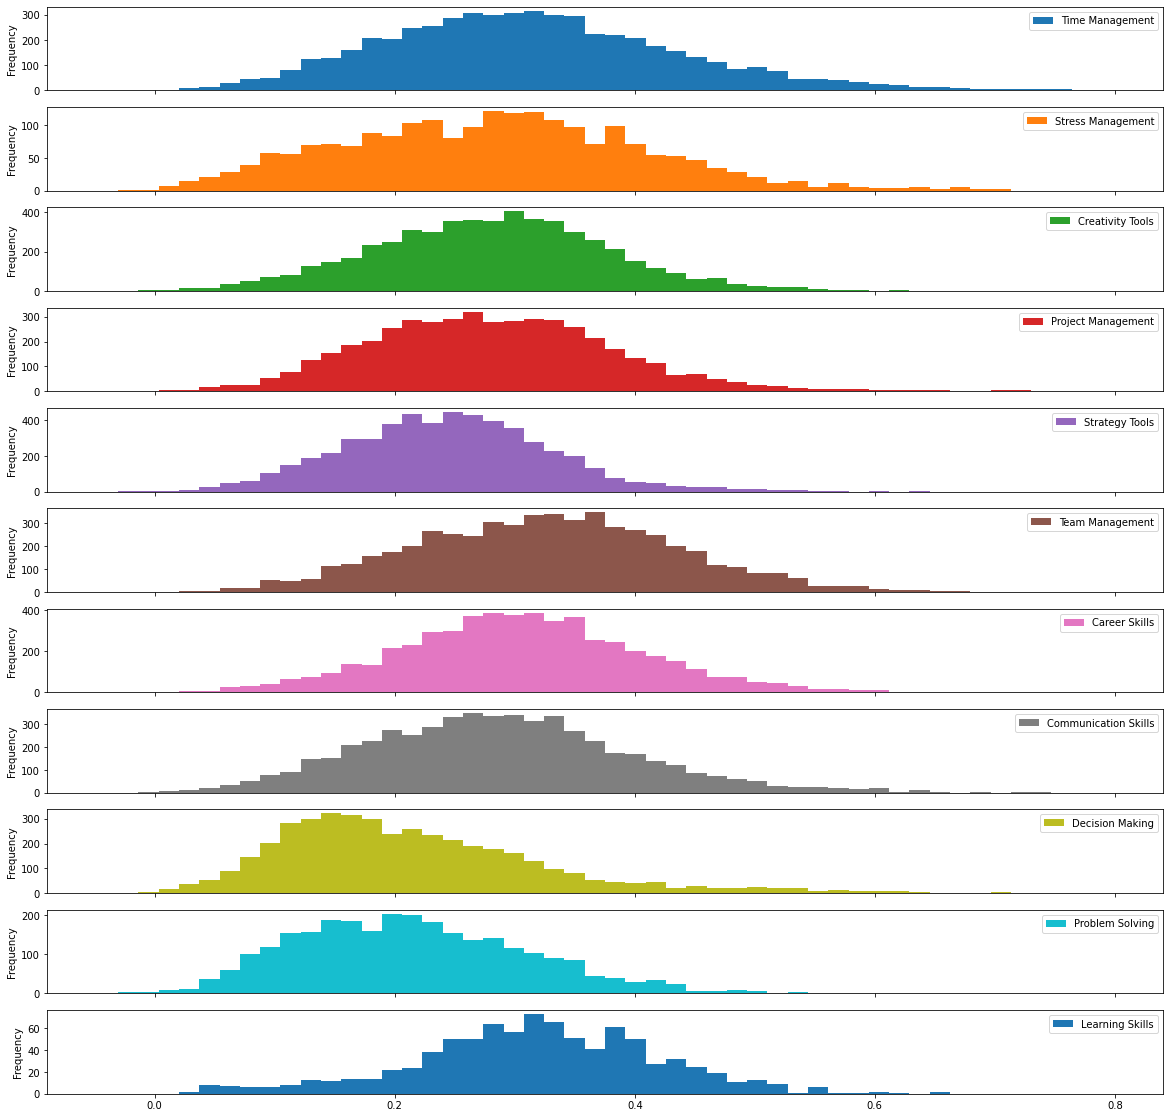

In [37]:
# Store and plot
df.to_excel('data/mindtools_experiments/skill_group_similarity.xlsx')
ax = df.plot.hist(bins=50, subplots=True, figsize=(20, 20))